In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Step 1: Load the dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/coupon.csv"
data = pd.read_csv(file_path)
output_path = "/content/drive/MyDrive/Data Science Projects/App/app/static"
os.makedirs(output_path, exist_ok=True)


In [8]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")


Column Details:
Column: COUPON_UPC, Type: int64, Unique values: 1135
Column: PRODUCT_ID, Type: int64, Unique values: 44133
Column: CAMPAIGN, Type: int64, Unique values: 30


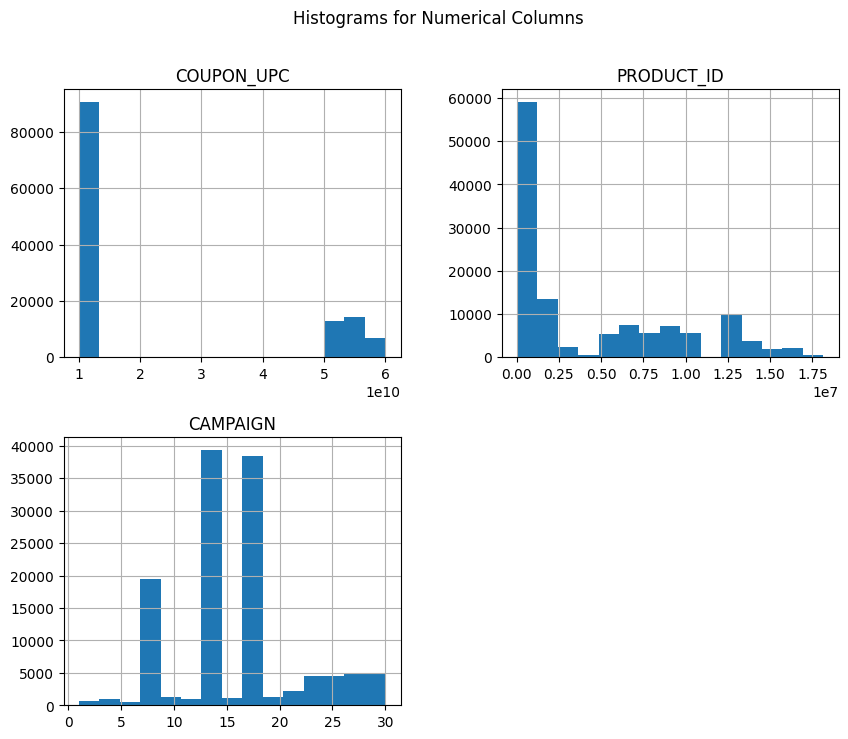

In [9]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "cupon_histograms.png"))

In [10]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)

# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")

Number of missing values in each column before filling:
COUPON_UPC    0
PRODUCT_ID    0
CAMPAIGN      0
dtype: int64

Values used to fill columns with missing values:
COUPON_UPC: 21982253584.326275
PRODUCT_ID: 4651276.621182195
CAMPAIGN: 15.855935061181231


In [11]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


Outliers Detected for CAMPAIGN:
         COUPON_UPC  PRODUCT_ID  CAMPAIGN
0       10000089061       27160         4
3       51800009050       28919        28
7       52100026076       28929        28
8       52100020075       28929         1
12      52100026076       29096        28
...             ...         ...       ...
124455  52770031050      110028        26
124456  52770031050     1111344        26
124457  52770031050     1949053        26
124458  53700067076     5125479        26
124459  53700067076     5566800        26

[15465 rows x 3 columns]


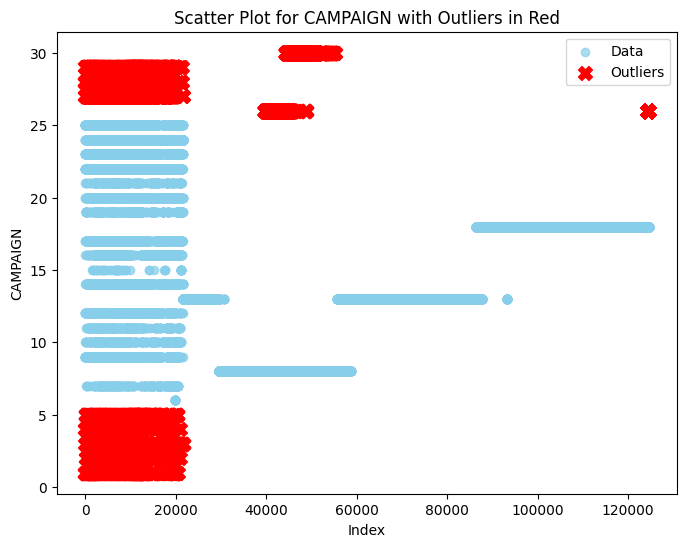

In [12]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"cupon_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)


In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='CAMPAIGN', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CAMPAIGN Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "cupon_outliers_CAMPAIGN.png"))

In [13]:
cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers

In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='CAMPAIGN', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CAMPAIGN Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "cupon_removed_outliers_CAMPAIGN.png"))

In [14]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['CAMPAIGN'] = label_encoder.fit_transform(data['CAMPAIGN'])


In [15]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Loan_Status')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'CAMPAIGN':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [16]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['CAMPAIGN'])  # Features
y = data['CAMPAIGN']  # Target variable

# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Step 11: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}


In [20]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

In [21]:
# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)

In [22]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

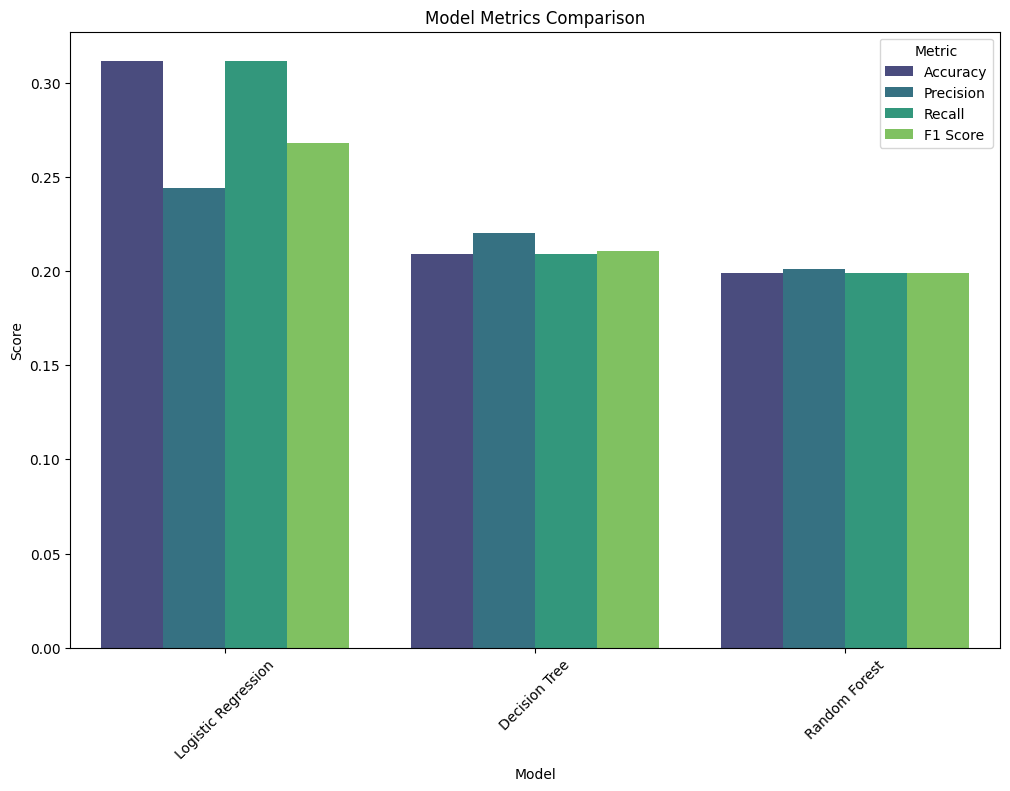

In [23]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "cupon_metrics.png"))

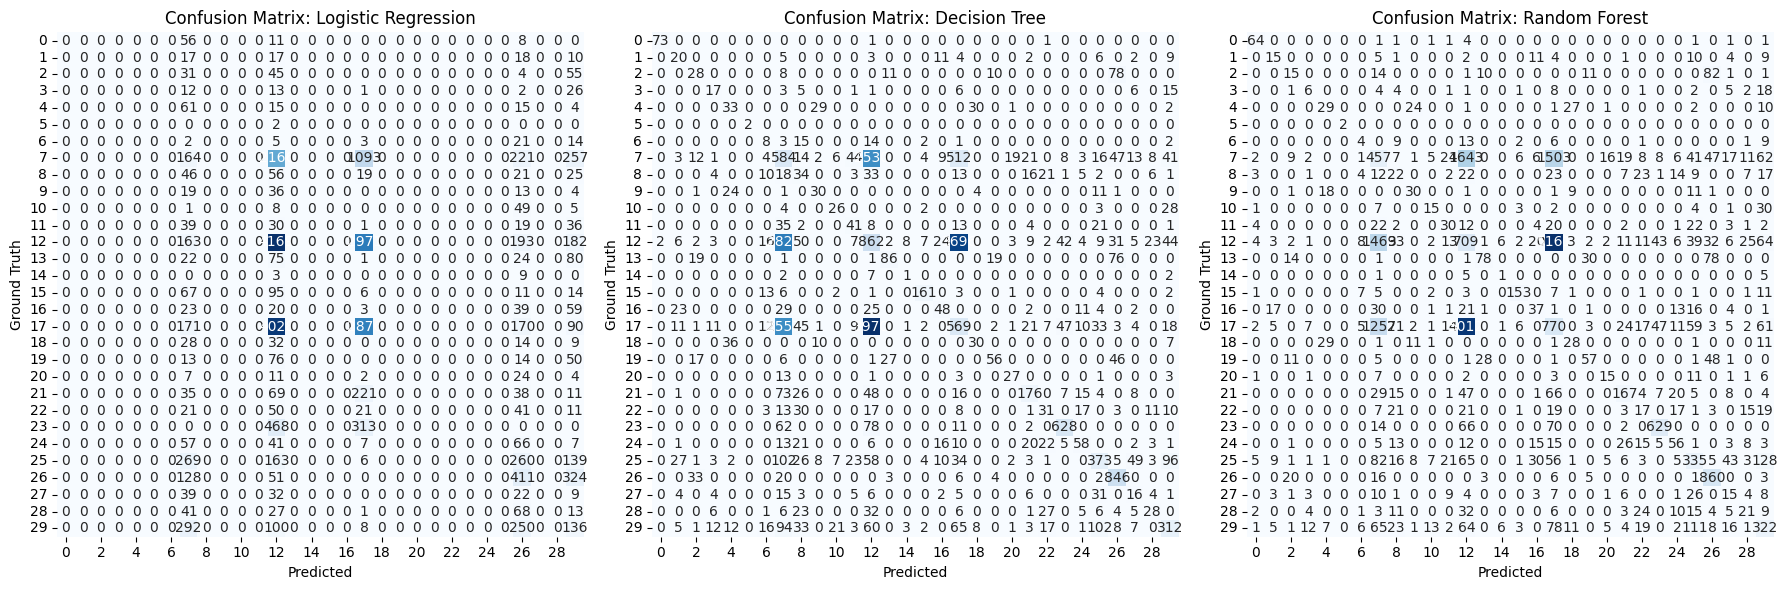

In [24]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "cupon_metrix.png"))

In [25]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00        62
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00        95
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        45
           7       0.09      0.04      0.06      3901
           8       0.00      0.00      0.00       167
           9       0.00      0.00      0.00        72
          10       0.00      0.00      0.00        63
          11       0.00      0.00      0.00       125
          12       0.35      0.54      0.43      7678
          13       0.00      0.00      0.00       202
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00       193
          16       0.00      0.00